# Load MNIST Dataset



In [27]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import RandomSampler

import torchvision
import torchvision.transforms as transforms

# https://pytorch.org/vision/stable/datasets.html
train_set = torchvision.datasets.MNIST(
    'D:/data', train=True, transform=transforms.ToTensor(), download=True)
test_set = torchvision.datasets.MNIST(
    'D:/data', train=False, transform=transforms.ToTensor(), download=True)

# This sampler will run for 10k training steps
# https://pytorch.org/docs/stable/data.html#torch.utils.data.RandomSampler
sampler = RandomSampler(train_set,
                        replacement=True,  # 복원 추출
                        num_samples=100 * 10000)

# Use the sampler to create a data loader
train_loader = DataLoader(
    train_set, batch_size=100, sampler=sampler, num_workers=4)

# Test loader runs for 1 epoch
test_loader = DataLoader(
    test_set, batch_size=200, num_workers=4)

In [28]:
sample = next(iter(test_loader))
sample[0].shape, sample[1].shape

(torch.Size([200, 1, 28, 28]), torch.Size([200]))

In [29]:
# Let's take a look at train dataset
print(f"Size of train set: {len(train_set)}")
index = 12
x, y = train_set[index]
print(f"Input shape: {x.shape}")
print(f"Label: {y}")
transforms.functional.to_pil_image(x)

Size of train set: 60000
Input shape: torch.Size([1, 28, 28])
Label: 3


# Types of Neural Networks

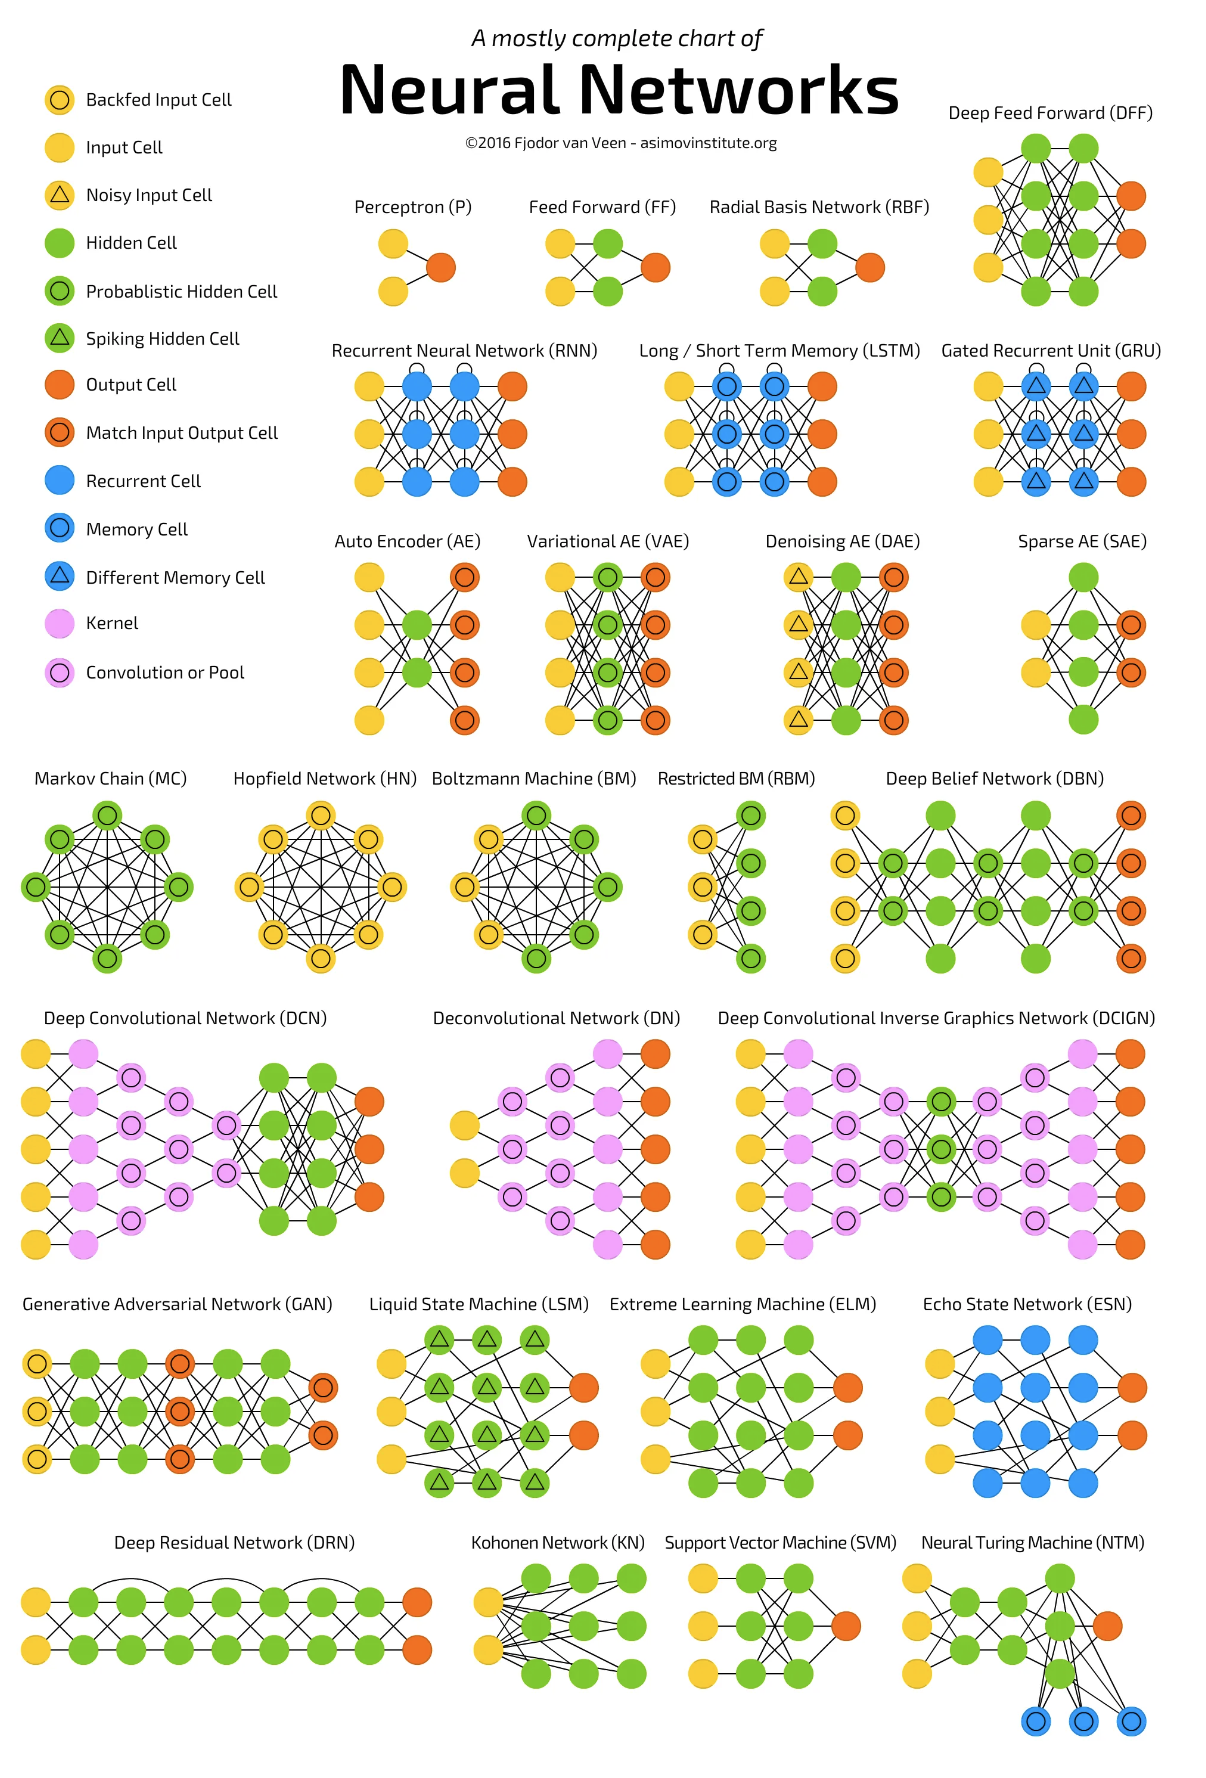

Reference: https://www.researchgate.net/publication/341373030_The_Neural_Network_Zoo

# Build a Neural Network

`torch.nn` provides common building blocks of neural networks.

In [30]:
import torch.nn as nn
import torch.nn.functional as F

## `nn.Module`

To create a neural network module, you need to define a class inheriting `nn.Module` class. In the new class, you should define `__init__` and `forward` methods. When a module is instantiated (e.g., `your_module = YourModule()`), it can be used like a function (e.g., `output = your_module(input)`). When used like a function, `nn.Module` calls the `forward` method internally to process the input. So be careful not to mistype the name.

The following is a simple multi-layer perceptron (MLP) network with two hidden layers, each containing 200 hidden units. (`x - h1 - h2 - y`)

In [31]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer1 = nn.Linear(1 * 28 * 28, 200)  # MNIST image size
        self.layer2 = nn.Linear(200, 200)
        self.layer3 = nn.Linear(200, 10)  # MNIST has 10 classes

    def forward(self, x):
        # x: (B, 1, 28, 28)
        x = x.view(x.shape[0], -1)  # flatten, (B, 1*28*28)
        h1 = F.relu(self.layer1(x)) # (B, 200)
        h2 = F.relu(self.layer2(h1)) # (B, 200)
        return F.log_softmax(self.layer3(h2), dim=1) # (B, 10)

> Note:`torch.nn` only supports mini-batches. The entire ``torch.nn`` package only supports inputs that are a mini-batch of samples, and not a single sample. For example, `nn.Linear` will take in a 2D Tensor of
`nSamples x nChannels`. [(torch.nn.Linear)](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)

You may also use `nn.Sequential` module. Specify `nn` modules when creating `nn.Sequential`, then the modules are run sequentially.



Why does RELU activation function work? [link](https://adityashrm21.github.io/Why-Rectified-Linear-Units-Work/)

In [32]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(1 * 28 * 28, 200),  # MNIST image size
            nn.ReLU(),
            nn.Linear(200, 200),
            nn.ReLU(),
            nn.Linear(200, 10),  # MNIST has 10 classes
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = x.view(x.shape[0], -1)  # flatten, (B, 1*28*28)
        return self.net(x)

You can use the module like this:

In [33]:
device = 'cuda' #'cuda'

# Instantiate
model = MLP().to(device)  # use .to() to use GPU

# Load a mini-batch (just a test)
x, y = next(iter(train_loader))
x, y = x.to(device), y.to(device)  # you also need to send data to GPU
print(x.shape)
print(y.shape)

# Forward it through the model
pred = model(x)
print(pred.shape)

torch.Size([100, 1, 28, 28])
torch.Size([100])
torch.Size([100, 10])


In [34]:
pred[0]

tensor([-2.3447, -2.2631, -2.3645, -2.2588, -2.2549, -2.2681, -2.3562, -2.3787,
        -2.2613, -2.2870], device='cuda:0', grad_fn=<SelectBackward0>)

In [35]:
torch.exp(pred[0]), torch.exp(pred[0]).sum()

(tensor([0.0959, 0.1040, 0.0940, 0.1045, 0.1049, 0.1035, 0.0948, 0.0927, 0.1042,
         0.1016], device='cuda:0', grad_fn=<ExpBackward0>),
 tensor(1., device='cuda:0', grad_fn=<SumBackward0>))

In [36]:
y[0]

tensor(6, device='cuda:0')

## Loss Function

A loss function takes the (output, target) pair of inputs, and computes a value that estimates how far away the output is from the target.

There are several different loss functions under the `nn` package (https://pytorch.org/docs/stable/nn.html#loss-functions). For classification, we use `nn.NLLLoss` which is basically cross-entropy loss.

> Note: We use `nn.NLLLoss` because our model's last modules is `nn.LogSoftmax`, which outputs log-probability of each class. You may omit the `nn.LogSoftmax` and use `nn.CrossEntropyLoss` as the loss function, which combines `nn.LogSoftmax` and `nn.NLLLoss` in a single module. [reference](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)

In [37]:
# https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html
criterion = nn.NLLLoss()
loss = criterion(pred, y)
print(loss)

tensor(2.3004, device='cuda:0', grad_fn=<NllLossBackward0>)


## Optimizer

The simplest update rule used in practice is the Stochastic Gradient
Descent (SGD):
```python
     weight = weight - learning_rate * gradient
```
We can implement this using simple Python code:
```python
    learning_rate = 0.01
    for f in net.parameters():
        f.data.sub_(f.grad.data * learning_rate)
```

However, as you use neural networks, you want to use various different
update rules such as SGD, Nesterov-SGD, Adam, RMSProp, etc.
PyTorch offers these algorithms in `torch.optim` package. Using it is very simple:

In [38]:
for f in model.parameters():
    print(f.data.shape, f.requires_grad)

torch.Size([200, 784]) True
torch.Size([200]) True
torch.Size([200, 200]) True
torch.Size([200]) True
torch.Size([10, 200]) True
torch.Size([10]) True


In [39]:
import torch.optim as optim

# create your optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

# in your training loop:
optimizer.zero_grad()  # zero the gradient buffers
loss.backward()  # backprop
# check gradient
for f in model.parameters():
    print(f.grad.data.shape)
    print(f.grad.data)
    print(f.grad.data.sum()) # gradient
    print(f.sum()) # parameter
    break
optimizer.step()  # does the update

torch.Size([200, 784])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')
tensor(3.3211, device='cuda:0')
tensor(-5.1820, device='cuda:0', grad_fn=<SumBackward0>)


In the above code, we calculated the sum of the parameters at the end. If we calculate this again, we can see that the values of parameters have changed. This is due to the update with `optimizer.step()`.

In [40]:
for f in model.parameters():
    print(f.grad.data.sum()) # gradient
    print(f.sum()) # parameter
    break

tensor(3.3211, device='cuda:0')
tensor(-5.2152, device='cuda:0', grad_fn=<SumBackward0>)


# Training

## Basic Training Loop

### Initialization
1. Define the model (MLP()) and move it to the correct device.
2. Use nn.NLLLoss() as the loss function.
3. Set up the optimizer (SGD) with a learning rate.

### Training Loop

1. Iterate over batches from train_loader.
2. Move data (x, y) to the correct device.
3. Reset gradients using optimizer.zero_grad().
4. Perform a forward pass: compute predictions.
5. Compute loss using the criterion.
Perform backpropagation with loss.backward().
6. Update model parameters using optimizer.step().

Now we are going to learn how to monitor the training process and save the trained model for later use.

In [51]:
# TODO: Implement basic training loop

from tqdm.autonotebook import tqdm

device = 'cuda'

model = MLP().to(device)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01,)

for step, (x, y) in enumerate(tqdm(train_loader), start=1):
  # 1. move x, y to cuda
  x, y = x.to(device), y.to(device)
  # 2. reset gradient of optimizer
  optimizer.zero_grad()
  # 3. forward pass
  pred = model(x)
  # 4. compute loss using criterion
  loss = criterion(pred, y)
  # 5. loss backward using optimizer
  loss.backward()
  optimizer.step()

100%|██████████| 10000/10000 [00:16<00:00, 608.26it/s]


### Model Evaluation

1. Call model.eval() (to disable dropout and batch normalization updates)
2. Evaluation Metrics
  - accuracy
  - test_loss
3. Move data (x, y) to the correct device (CPU/GPU).
4. Use torch.no_grad() to disable gradient computation, saving memory and speeding up inference.
5. Compute Predictions and Loss
  - Perform a forward pass with model(x).
  - Compute the loss using the criterion.
  - Find model prediction and compute accuracy
6. Find the class with the highest probability using pred.max(dim=1).
  - Compare predictions with ground truth (y) and count correct predictions.
7. Print Final Results

In [52]:
# TODO: Implement model evaluation

model.eval()
total, correct = 0, 0
test_loss = 0
for x, y in test_loader:
    # 1. move data to cuda
    x, y = x.to(device), y.to(device)

    # 2. Don't compute gradient during evaluation (hint: torch.no_grad())
    with torch.no_grad():
        pred = model(x)

    # 3. Compute the loss
    test_loss += criterion(pred, y) * x.shape[0]

    # 4. Find prediction and compute accuracy
    total += x.shape[0]
    correct += (pred.argmax(dim=1) == y).sum()

test_loss /= total
accuracy = correct / total

print(f"Test Loss: {test_loss.item()}")
print(f"Test Accuracy: {accuracy.item() * 100:.2f}%")

Test Loss: 0.16101880371570587
Test Accuracy: 97.70%


## TensorBoard

TensorBoard is a visualization tool for deep learning. In PyTorch you can save numbers, histograms, images, audio, video, etc. during training and explore them in TensorBoard.
You can open tensorboard with the following shell command:
```sh
tensorboard --logdir YOUR_LOG_DIRECTORY
```

In [53]:
%load_ext tensorboard

In [57]:
%tensorboard --logdir log

Reusing TensorBoard on port 6006 (pid 16952), started 0:04:10 ago. (Use '!kill 16952' to kill it.)

It should be empty for now. Once you write summaries inside `log` directory, they will appear in the TensorBoard.

To write summaires, you need to use `SummaryWriter`.

In [55]:
from torch.utils.tensorboard import SummaryWriter

Now let's summarize training loss every 100 steps and evaluate test set every 1000 steps.

[torch.util.tensorboard](https://pytorch.org/docs/stable/tensorboard.html)

In [56]:
# TODO:
# Logging with TensorBoard (writer)
#    - 📌 Log training loss → 'loss/train'
#    - 📌 Log test loss → 'loss/test'
#    - 📌 Log test accuracy → 'accuracy'

from tqdm.autonotebook import tqdm

device = 'cuda'

model = MLP().to(device)
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
writer = SummaryWriter('log/run1')

for step, (x, y) in enumerate(tqdm(train_loader), start=1):
    model.train()
    x, y = x.to(device), y.to(device)
    optimizer.zero_grad()
    pred = model(x)
    loss = criterion(pred, y)
    loss.backward()
    optimizer.step()

    # Summary
    if step % 100 == 0:
        # 1. Log training loss
        writer.add_scalar('loss/train', loss.detach(), step)
    # Eval
    if step % 1000 == 0:
        total, correct = 0, 0
        test_loss = 0
        model.eval()
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)

            # Don't compute gradient during evaluation
            with torch.no_grad():
                pred = model(x)

            test_loss += criterion(pred, y) * x.shape[0]

            total += x.shape[0]
            correct += (pred.max(dim=1)[1] == y).sum()

        test_loss /= total
        accuracy = correct / total

        # 2. Log test loss
        writer.add_scalar('loss/test', test_loss, step)
        # 3. Log test accuracy
        writer.add_scalar('acc', accuracy, step)

100%|██████████| 10000/10000 [01:06<00:00, 151.48it/s]


## Checkpoints

During training, you can save the model parameters and load them later for other uses. `nn.Module` and optimizers can export themselves as *state dictionary*.
```python
# Save checkpoint
torch.save({
    'step': step,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()},
    PATH)

# Load checkpoint
model = MLP().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

checkpoint = torch.load(PATH)
step = checkpoint['step']
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
```

In [58]:
print(model.state_dict())
print(model.state_dict().keys())

OrderedDict([('net.0.weight', tensor([[ 0.0338,  0.0027, -0.0277,  ..., -0.0223,  0.0061, -0.0320],
        [ 0.0014, -0.0090,  0.0068,  ..., -0.0316,  0.0217,  0.0134],
        [ 0.0222, -0.0152, -0.0143,  ...,  0.0346, -0.0149,  0.0308],
        ...,
        [-0.0044,  0.0090,  0.0153,  ...,  0.0323,  0.0127,  0.0193],
        [-0.0311,  0.0158,  0.0061,  ...,  0.0207, -0.0079,  0.0259],
        [-0.0159, -0.0192,  0.0009,  ..., -0.0105, -0.0284,  0.0166]],
       device='cuda:0')), ('net.0.bias', tensor([-1.0515e-01,  3.0837e-02,  7.5405e-02, -1.1405e-02,  6.0701e-02,
        -5.5890e-02,  1.4675e-02, -4.0059e-03,  5.3461e-03, -1.9449e-02,
        -1.9205e-02, -8.2752e-02,  1.1993e-04,  3.9449e-02, -5.6163e-02,
         1.4566e-03, -1.2322e-02, -9.2052e-02,  5.9441e-03,  1.8186e-02,
        -1.6386e-01,  9.1546e-02, -1.6734e-01, -1.1246e-02,  7.0429e-02,
         8.5053e-02,  3.0657e-02, -1.2981e-02,  5.6126e-02,  7.0757e-02,
         3.1295e-02,  3.2857e-02,  1.5600e-01,  6.3636e-0

Now let's periodically save checkpoints in out training loop.

[torch save & load](https://pytorch.org/tutorials/beginner/saving_loading_models.html#save)

In [60]:
# TODO:
# Save model checkpoints
#    - 📌 Store model state & optimizer state
#    - 📌 Save periodically for resuming training

log_dir = 'log/run2'
model = MLP().to(device)
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
writer = SummaryWriter(log_dir)

for step, (x, y) in enumerate(tqdm(train_loader), start=1):
    model.train()
    x, y = x.to(device), y.to(device)
    optimizer.zero_grad()
    pred = model(x)
    loss = criterion(pred, y)
    loss.backward()
    optimizer.step()

    # Summary
    if step % 100 == 0:
        writer.add_scalar('loss/train', loss.detach(), step)

    # Eval
    if step % 1000 == 0:
        model.eval()
        total, correct = 0, 0
        test_loss = 0
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)

            # Don't compute gradient during evaluation
            with torch.no_grad():
                pred = model(x)

            test_loss += criterion(pred, y) * x.shape[0]

            total += x.shape[0]
            correct += (pred.max(dim=1)[1] == y).sum()

        test_loss /= total
        accuracy = correct / total

        writer.add_scalar('loss/test', test_loss, step)
        writer.add_scalar('accuracy', accuracy, step)

        # Save checkpoint
        torch.save({'step':step,
                    'model_state_dict':model.state_dict(),
                    'optimizer_state_dict':optimizer.state_dict()}, 
                    log_dir + '/ckpt-{}.pt'.format(step))

100%|██████████| 10000/10000 [01:06<00:00, 150.28it/s]


Check the *Files* tab to see if the checkpoints are saved correctly.
Then load the checkpoints to a new model:

In [61]:
new_model = MLP().to(device)
checkpoint = torch.load('log/run2/ckpt-10000.pt')
new_model.load_state_dict(checkpoint['model_state_dict'])

C:\Users\HP\AppData\Local\Temp\ipykernel_18272\1248791959.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('log/run2/ckpt-10000.pt')


<All keys matched successfully>

In [62]:
new_model.eval()
total, correct = 0, 0
test_loss = 0
for x, y in test_loader:
    x, y = x.to(device), y.to(device)

    # Don't compute gradient during evaluation
    with torch.no_grad():
        pred = new_model(x)

    test_loss += criterion(pred, y) * x.shape[0]

    total += x.shape[0]
    correct += (pred.max(dim=1)[1] == y).sum()

test_loss /= total
accuracy = correct / total

print(f"Test Loss: {test_loss.item()}")
print(f"Test Accuracy: {accuracy.item() * 100:.2f}%")

Test Loss: 0.06645787507295609
Test Accuracy: 97.89%


# Exercise

## CIFAR10 Image Classification

For this exercise, we will use the CIFAR10 dataset.
There are 10 classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.


![CIFAR10](http://pytorch.org/tutorials/_images/cifar10.png)



We will do the following steps in order:

1. Load the CIFAR10 training and test datasets using `torchvision`
2. Build an MLP Neural Network for CIFAR10
3. Build training loop
4. Try various network architecture, optimizer, hyperparameters, etc. to improve performance.


### 1. Load CIFAR10 Dataset

Similar to MNIST, you can use CIFAR10 dataset in `torchvision.datasets.CIFAR10`.
Get the train and test set of CIFAR10, and create data loaders.

In [67]:
# TODO
# Hint: copy/paste from above and change MNIST to CIFAR10

import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import RandomSampler

import torchvision
import torchvision.transforms as transforms

# https://pytorch.org/vision/stable/datasets.html
train_set = torchvision.datasets.CIFAR10(
    'D:/data', train=True, transform=transforms.ToTensor(), download=True)
test_set = torchvision.datasets.CIFAR10(
    'D:/data', train=False, transform=transforms.ToTensor(), download=True)

# This sampler will run for 10k training steps
# https://pytorch.org/docs/stable/data.html#torch.utils.data.RandomSampler
sampler = RandomSampler(train_set,
                        replacement=True,  # 복원 추출
                        num_samples=100 * 10000)

# Use the sampler to create a data loader
train_loader = DataLoader(
    train_set, batch_size=100, sampler=sampler, num_workers=4)

# Test loader runs for 1 epoch
test_loader = DataLoader(
    test_set, batch_size=1024, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


Size of train set: 50000
Input shape: torch.Size([3, 32, 32])
Label: 7


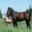

In [68]:
# Let's take a look at train dataset
print(f"Size of train set: {len(train_set)}")
index = 12
x, y = train_set[index]
print(f"Input shape: {x.shape}")
print(f"Label: {y}")
transforms.functional.to_pil_image(x)

### 2. Build MLP



In [71]:
# TODO
# Build MLP with 2 hidden layer for CIFAR10 dataset
# 1. change input size
# 2. (optional) change # of hidden layers / hidden layer size

class MLP(nn.Module):
    def __init__(self):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(3 * 32 * 32, 1024),  # MNIST image size
            nn.ReLU(),
            nn.Linear(1024, 200),
            nn.ReLU(),
            nn.Linear(200, 10),  # MNIST has 10 classes
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = x.view(x.shape[0], -1)  # flatten, (B, 1*28*28)
        return self.net(x)

### 3. Training Loop

In [72]:
# TODO
# run training on CIFAR10 dataset

log_dir = 'log/cifar10'
model = MLP().to(device)
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
writer = SummaryWriter(log_dir)

for step, (x, y) in enumerate(tqdm(train_loader), start=1):
    model.train()
    x, y = x.to(device), y.to(device)
    optimizer.zero_grad()
    pred = model(x)
    loss = criterion(pred, y)
    loss.backward()
    optimizer.step()

    # Summary
    if step % 100 == 0:
        writer.add_scalar('loss/train', loss.detach(), step)

    # Eval
    if step % 1000 == 0:
        model.eval()
        total, correct = 0, 0
        test_loss = 0
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)

            # Don't compute gradient during evaluation
            with torch.no_grad():
                pred = model(x)

            test_loss += criterion(pred, y) * x.shape[0]

            total += x.shape[0]
            correct += (pred.max(dim=1)[1] == y).sum()

        test_loss /= total
        accuracy = correct / total

        writer.add_scalar('loss/test', test_loss, step)
        writer.add_scalar('accuracy', accuracy, step)

        # Save checkpoint
        torch.save({'step':step,
                    'model_state_dict':model.state_dict(),
                    'optimizer_state_dict':optimizer.state_dict()}, 
                    log_dir + '/ckpt-{}.pt'.format(step))

100%|██████████| 10000/10000 [01:48<00:00, 92.57it/s]


In [73]:
model.eval()
total, correct = 0, 0
test_loss = 0
for x, y in test_loader:
    x, y = x.to(device), y.to(device)

    # Don't compute gradient during evaluation
    with torch.no_grad():
        pred = model(x)

    test_loss += criterion(pred, y) * x.shape[0]

    total += x.shape[0]
    correct += (pred.max(dim=1)[1] == y).sum()

test_loss /= total
accuracy = correct / total

print(f"Test Loss: {test_loss.item()}")
print(f"Test Accuracy: {accuracy.item() * 100:.2f}%")

Test Loss: 1.3789522647857666
Test Accuracy: 52.55%


In [74]:
%tensorboard --logdir log

Reusing TensorBoard on port 6006 (pid 16952), started 0:22:03 ago. (Use '!kill 16952' to kill it.)

### 4. Improve Performance

Here are some popular techniques to improve performance.
Try them and see how the performance varies.

- (Define validation set)
- Change learning rate (optimal learning rate is usually in range [0.0001, 0.1])
- Use different optimizers, e.g., `optim.Adam`
- Change the range of pixel values from [0, 1] to [-1, 1] (Use `transforms.Normalize`)
- Augment training data [link](https://pytorch.org/vision/0.15/transforms.html)
  - Random horizontal flip
  - Random crop
  - Random rotation
  - Color jitter
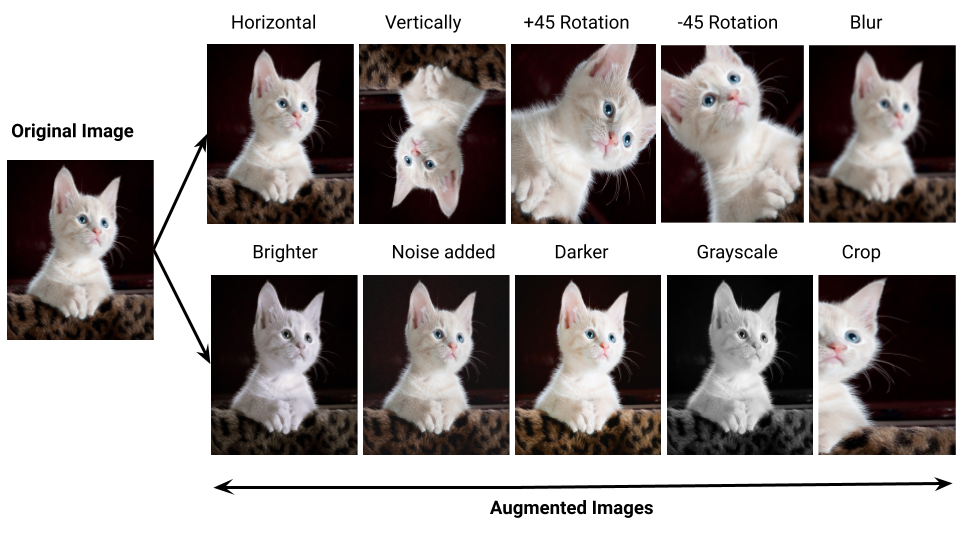

In [ ]:
# TODO
# try changing code above to achieve better performance on CIFAR10!